# Variational Autoencoders  

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, \
                        Flatten, Input, Conv2DTranspose, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython import display  

In [23]:
BATCH_SIZE=128
LATENT_DIM=2

## Prepare the Dataset

이 노트북에서 MNIST 데이터 세트의 'train' 분할을 사용합니다. 데이터 세트를 다운로드하고 준비하는 데 도움이되는 몇 가지 도우미 함수를 아래에 준비했습니다.

* `map_image()` - 이미지에서 텐서를 정규화하고 생성하여 이미지만 반환합니다. 이것은 오토인코더의 비지도 학습에 사용됩니다.

* `get_dataset()` - Tensorflow 데이터세트에서 MNIST를 로드하고 default로 'train' 분할을 가져온 다음 매핑 함수를 사용하여 준비합니다. `is_validation`이` True`로 설정되면 대신 `test` 분할을 받습니다. 

In [24]:
def map_image(image, label):
    '''주어진 이미지에서 정규화되고 재구성된 텐서를 반환합니다.'''
    image = tf.cast(image, dtype=tf.float32)
    image = image / 255.0
    image = tf.reshape(image, shape=(28, 28, 1,))
    return image

In [25]:
train_dataset = tfds.load('mnist', as_supervised=True, split="train")
train_dataset, len(train_dataset)

(<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 60000)

In [26]:
train_ds = train_dataset.map(map_image).shuffle(1024).batch(BATCH_SIZE)
train_ds

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

## Build the Model

이제 VAE 모델을 빌드합니다. 주요 부분은 아래 그림에 나와 있습니다.

<img src="https://drive.google.com/uc?export=view&id=1YAZAeMGEJ1KgieYk1ju-S9DoshpMREeC" width="60%" height="60%"/>

### Sampling Class

먼저 'Sampling' 클래스를 빌드합니다. 이것은 인코더 출력의 평균 (mu) 및 표준 편차 (sigma)와 함께 가우스 노이즈 입력을 제공하는 맞춤형 Keras 레이어입니다. 실제로 이 레이어의 출력은 다음 방정식으로 제공됩니다.

$$z = \mu + e^{0.5\sigma} * \epsilon  $$

여기서 $\mu$ = mean, $\sigma$ = standard deviation 이고 $\epsilon$ = random sample

In [27]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        """무작위 샘플을 생성하고 인코더 출력과 결합
        Args:
          inputs -- output tensor from the encoder (mu, sigma)
        Returns:
          `inputs` tensors combined with a random sample
        """
        # unpack the output of the encoder
        mu, sigma = inputs

        # get the size and dimensions of the batch
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]

        # generate a random tensor
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

        # reparameterization 적용
        return mu + tf.math.exp(0.5 * sigma) * epsilon

### Encoder

다음으로 네트워크의 인코더 부분을 빌드합니다. 다음과 같은 아키텍처를 따릅니다. mu 및 sigma 외에도 flattening하기 전에 피쳐의 모양도 출력합니다. 이것은 나중에 디코더에서 이미지를 재구성 할 때 유용합니다.

* 참고) 더 작은 배치로 batch normalization을 사용하는 데 문제가 발생할 수 있으며, 특히 VAE를 훈련할 때 batch normalization을 사용하지 않도록 조언되는 경우가 있습니다. 효과를 탐색하기 위해 이 노트북에서 추가하거나 제거하여 자유롭게 실험 해보십시오.

<img src="https://drive.google.com/uc?export=view&id=1eoxFK_UVSHd3a_5EHcCU8F8QDZlPiXfW" width="60%" height="60%"/>

인코더 레이어를 정의하면 아래 함수를 사용하여 '샘플링' 레이어를 포함하는 인코더 모델을 선언할 수 있습니다.

### Decoder

다음으로 잠재 표현을 원래 이미지 차원으로 다시 확장하는 네트워크의 디코더 부분을 구축합니다. 나중에 학습 루프에서 볼 수 있듯이이 모델에 임의의 입력을 제공하면 학습 데이터와 유사한 콘텐츠가 생성됩니다.

### Kullback–Leibler Divergence
모델의 생성 능력을 향상 시키려면 잠재 공간에 도입된 랜덤 정규 분포를 고려해야 합니다. 이를 위해 [Kullback–Leibler Divergence](https://arxiv.org/abs/2002.07514)가 계산되어 재구성 손실에 추가됩니다. 공식은 아래 함수에서 정의됩니다.

In [28]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
    """ Computes the Kullback-Leibler Divergence (KLD)
    Args:
    inputs -- batch from the dataset
    outputs -- output of the Sampling layer
    mu -- mean
    sigma -- standard deviation

    Returns:
    KLD loss
    """
    kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
    kl_loss = tf.reduce_mean(kl_loss) * -0.5

    return kl_loss

### VAE Model
이제 전체 VAE 모델을 정의할 수 있습니다. KL reconstruction loss를 추가하기 위해 `model.add_loss()`를 사용합니다. 이 손실을 계산하는 것은 `y_true`와 `y_pred`를 사용하지 않으므로 `model.compile()`에서 사용할 수 없습니다. 

- add_loss() 메서드 : 손실이 있는 경우, 자동으로 합산되어 주 손실에 추가

In [29]:
# encoder 
enc_inputs = Input(shape=(28,28,1,))
x = Conv2D(32, (3,3), strides=2, padding="same", activation='relu')(enc_inputs)
before_flatten = Conv2D(64, (3,3), strides=2, padding='same', activation='relu')(x)

# flatten the features and feed into the Dense network
x = Flatten()(before_flatten)
x = Dense(20, activation='relu')(x)

# 선언된 latent_dim과 동일한 unit의 mu 및 sigma에 대한 output Dense 네트워크를 추가합니다.
mu = Dense(LATENT_DIM)(x)
sigma = Dense(LATENT_DIM)(x)
z = Sampling()((mu, sigma))

encoder = Model(enc_inputs, outputs=[mu, sigma, z])

shape = before_flatten.shape

# decoder 
dec_inputs = Input(shape=(LATENT_DIM,))

# shape 차원을 사용하여 Dense 네트워크에 피드
x = Dense( shape[1] * shape[2] * shape[3], activation = 'relu')(dec_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# feature를 원래 크기로 다시 업샘플링
x = Conv2DTranspose(64, (3,3), strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(32, (3,3), strides=2, padding='same', activation='relu')(x)
outputs = Conv2DTranspose(1, (3,3), strides=1, padding='same', activation='sigmoid')(x)

decoder = Model(dec_inputs, outputs)

# vae model 
vae_inputs = enc_inputs
# get reconstructed output from the decoder
mu, sigma, z = encoder(vae_inputs)
reconstructed = decoder(z)

vae = Model(vae_inputs, reconstructed)
# add the KL loss
loss = kl_reconstruction_loss(vae_inputs, z, mu, sigma)
vae.add_loss(loss)

In [30]:
# plot_model(encoder, show_shapes=True)

In [31]:
# plot_model(decoder, show_shapes=True)

## Train the Model

이제 학습을 위해 VAE 모델을 설정할 수 있습니다. 재구성 손실, 옵티마이저 및 메트릭을 정의하는 것으로 시작 하겠습니다.

In [32]:
optimizer = tf.keras.optimizers.Adam()
loss_metric = tf.keras.metrics.Mean()
bce_loss = tf.keras.losses.BinaryCrossentropy()

각 epoch의 이미지 생성 진행 상황을보고 싶을 것입니다. 이를 위해 아래 도우미 기능을 사용할 수 있습니다. 그러면 4x4 그리드에 16 개의 이미지가 생성됩니다.

In [33]:
def generate_and_save_images(model, epoch, step, test_input):
    """Helper function to plot our 16 images
    Args:
    epoch -- current epoch number during training
    step -- current step number during training
    test_input -- random tensor with shape (16, LATENT_DIM)
    """
    # generate images from the test input
    predictions = model.predict(test_input)

    # plot the results
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    fig.suptitle("epoch: {}, step: {}".format(epoch, step))
    plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
    plt.show()

훈련 루프는 아래와 같습니다. 이렇게하면 생성된 이미지가 epoch마다 표시되며 완료하는 데 약 30 분이 걸립니다. 그래디언트를 얻고 가중치를 업데이트하기 전에 KLD 손실을 이진 교차 엔트로피 손실에 추가합니다.

초기 16 개 이미지는 무작위로 보이지만 네트워크가 학습함에 따라 시간이 지나면 개선되고 MNIST 데이터 세트와 유사한 이미지가 표시됩니다.

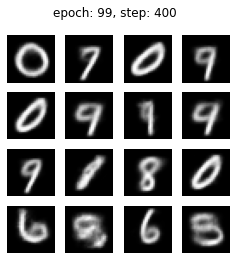

Epoch: 99 step: 400 mean loss = 142.0666


In [34]:
# Training loop. 

#디코더에 대한 테스트 입력으로 랜덤 벡터 생성
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])

epochs = 100

# 훈련되지 않은 모델의 출력을 표시하도록 도우미 함수를 초기화합니다.
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))

    for step, x_batch_train in enumerate(train_ds):
        with tf.GradientTape() as tape:

            # VAE 모델에 배치 공급
            reconstructed = vae(x_batch_train)

            # 재구성 손실 계산
            flattened_inputs   = tf.reshape(x_batch_train, shape=[-1])
            flattened_outputs = tf.reshape(reconstructed, shape=[-1])
            loss = bce_loss(flattened_inputs, flattened_outputs) * 784

            # add KLD regularization loss
            loss += sum(vae.losses)  

        # get the gradients and update the weights
        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))

        # compute the loss metric
        loss_metric(loss)

        # display outputs every 100 steps
        if step % 100 == 0:
            display.clear_output(wait=False)    
            generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
            print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))

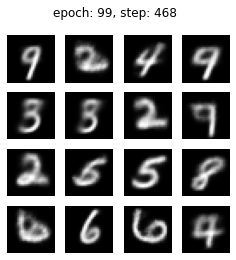

In [39]:
display.clear_output(wait=False)
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])
generate_and_save_images(decoder, epoch, step, random_vector_for_generation)